In [ ]:
from dataclasses import dataclass, field
from typing import Optional
import torch

@dataclass
class TrainingConfig:
    """All hyperparameters for DQN training."""
    # Session
    seed: Optional[int] = None
    train: bool = True
    model_path: Optional[str] = None
    render_mode: Optional[str] = None  # "human", "ansi", or None
    time_step_delay_secs: float = 0.5
    
    # Training bounds
    num_episodes: int = 100_000
    num_total_steps: int = 10_000_000
    
    # DQN hyperparameters
    learning_rate: float = 0.001
    discount_factor: float = 0.99
    batch_size: int = 512
    replay_buffer_capacity: int = 1_000_000
    
    # Epsilon-greedy schedule
    epsilon_start: float = 1.0
    epsilon_end: float = 0.1
    epsilon_decay_steps: int = 4_000_000
    
    # Update frequencies
    training_frequency: int = 4
    target_update_frequency: int = 10_000
    checkpoint_frequency: int = 100_000
    learning_start_step: int = 1_000_000
    
    # Logging
    log_frequency: int = 100
    plot_rolling_length: int = 1000
    
    # Computed
    device: torch.device = field(init=False)
    
    def __post_init__(self):
        self.device = torch.device(
            "cuda" if torch.cuda.is_available()
            else "mps" if torch.backends.mps.is_available()
            else "cpu"
        )

# Instantiate config
config = TrainingConfig()
print(f"Using device: {config.device}")

Using device: mps


In [2]:
from collections import deque, namedtuple
from torch.utils.tensorboard import SummaryWriter
import datetime
import gymnasium as gym
import numpy as np
import os
import random
import secrets
import time
import torch
import torch.nn as nn
import torch.optim as optim

from tetris_gymnasium.envs import Tetris

def set_seed(seed: int):
    """Set all random seeds for reproducibility."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Generate or use provided seed
if config.seed is None:
    config.seed = secrets.randbits(32)
set_seed(config.seed)
print(f"Using seed: {config.seed}")

Using seed: 598888965


In [3]:
def preprocess_tetris_observation(obs: dict, device: torch.device) -> torch.Tensor:
    """
    Preprocess Tetris observation for CNN input.
    
    Converts the observation dictionary into a 4-channel tensor:
    - Channel 0: Board state (binary: filled/empty)
    - Channel 1: Active tetromino mask
    - Channel 2: Queue (next pieces, rotated and padded)
    - Channel 3: Holder piece (padded)
    
    Args:
        obs: Dictionary with 'board', 'active_tetromino_mask', 'queue', 'holder'
        device: Target torch device
        
    Returns:
        Tensor of shape (1, 4, 20, 10)
    """
    # Board: Remove padding (24x18 -> 20x10), binarize
    board = obs['board'][:20, 4:14].copy()
    board[board != 0] = 1
    
    # Mask: Remove padding to 20x10
    mask = obs['active_tetromino_mask'][:20, 4:14].copy()
    
    # Queue: Rotate CCW and pad from 4x16 -> 16x4 -> 20x10
    queue = np.rot90(obs['queue'].copy())  # Now 16x4
    queue = np.pad(queue, ((2, 2), (3, 3)), mode='constant')  # 20x10
    
    # Holder: Handle empty state (all 1s = empty), pad from 4x4 -> 20x10
    holder = obs['holder'].copy()
    if np.all(holder == 1):
        holder.fill(0)
    holder = np.pad(holder, ((8, 8), (3, 3)), mode='constant')  # 20x10
    
    # Stack channels: (4, 20, 10) -> (1, 4, 20, 10)
    stacked = np.array([board, mask, queue, holder], dtype=np.float32)
    return torch.from_numpy(stacked).unsqueeze(0).to(device)

In [4]:
class QCNN(nn.Module):
    """
    CNN-based Q-Network for Tetris.
    
    Architecture:
    - 2 convolutional blocks with depth-wise separated convolutions
    - GroupNorm for channel-independent normalization
    - Fully connected layers for Q-value output
    
    Input: (batch, 4, 20, 10) preprocessed Tetris observation
    Output: (batch, num_actions) Q-values for each action
    """
    NAME = "QCNN_v2"
    
    def __init__(self, num_actions: int):
        super().__init__()
        
        self.network = nn.Sequential(
            # Block 1: Depthwise conv over each channel
            nn.Conv2d(4, 32, kernel_size=4, stride=2, padding=2, groups=4),
            nn.MaxPool2d(kernel_size=2),
            nn.GroupNorm(num_groups=4, num_channels=32),
            nn.ReLU(),
            
            # Block 2: Depthwise conv over filter sets
            nn.Conv2d(32, 64, kernel_size=2, stride=1, padding=0, groups=4),
            nn.MaxPool2d(kernel_size=2),
            nn.GroupNorm(num_groups=32, num_channels=64),
            nn.ReLU(),
            
            # Dense layers
            nn.Flatten(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, num_actions)
        )
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.network(x)
    
    @staticmethod
    def preprocess(obs: dict, device: torch.device) -> torch.Tensor:
        """Preprocess observation for this network."""
        return preprocess_tetris_observation(obs, device)

In [5]:
Transition = namedtuple('Transition', ('state', 'action', 'reward', 'next_state', 'done'))

class ReplayBuffer:
    """Fixed-size circular buffer for storing experience transitions."""
    
    def __init__(self, capacity: int):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, done):
        """Store a transition."""
        self.buffer.append(Transition(state, action, reward, next_state, done))
    
    def sample(self, batch_size: int) -> list:
        """Randomly sample a batch of transitions."""
        return random.sample(self.buffer, batch_size)
    
    def __len__(self) -> int:
        return len(self.buffer)

In [6]:
class DQNAgent:
    """
    Deep Q-Network agent with experience replay and target network.
    """
    
    def __init__(self, config: TrainingConfig, num_actions: int, writer: SummaryWriter):
        self.config = config
        self.num_actions = num_actions
        self.writer = writer
        self.device = config.device
        
        # Networks
        self.online_net = QCNN(num_actions).to(config.device)
        self.target_net = QCNN(num_actions).to(config.device)
        self.target_net.load_state_dict(self.online_net.state_dict())
        self.target_net.eval()
        
        # Optimizer
        self.optimizer = optim.AdamW(
            self.online_net.parameters(), 
            lr=config.learning_rate, 
            amsgrad=True
        )
        
        # Replay buffer
        self.replay_buffer = ReplayBuffer(config.replay_buffer_capacity)
        
        # State tracking
        self.epsilon = config.epsilon_start
        self.total_steps = 0
        self.training_steps = 0
        
        # Loss function
        self.loss_fn = nn.SmoothL1Loss()
        
        # Load checkpoint if provided
        if config.model_path:
            self._load_checkpoint(config.model_path)
    
    def select_action(self, state: dict) -> int:
        """Epsilon-greedy action selection."""
        if random.random() < self.epsilon:
            return random.randint(0, self.num_actions - 1)
        
        self.online_net.eval()
        with torch.no_grad():
            state_tensor = QCNN.preprocess(state, self.device)
            q_values = self.online_net(state_tensor)
            return q_values.argmax(dim=1).item()
    
    def store_transition(self, state, action, reward, next_state, done):
        """Store transition in replay buffer (preprocessed)."""
        state_t = QCNN.preprocess(state, self.device)
        next_state_t = QCNN.preprocess(next_state, self.device) if not done else None
        reward_t = torch.tensor([reward], device=self.device, dtype=torch.float32)
        action_t = torch.tensor([[action]], device=self.device, dtype=torch.int64)
        
        self.replay_buffer.push(state_t, action_t, reward_t, next_state_t, done)
        self.total_steps += 1
    
    def update_epsilon(self):
        """Decay epsilon linearly after warmup period."""
        if self.total_steps < self.config.learning_start_step:
            return
        
        steps_since_learning = self.total_steps - self.config.learning_start_step
        decay_progress = min(1.0, steps_since_learning / self.config.epsilon_decay_steps)
        self.epsilon = self.config.epsilon_start - (
            (self.config.epsilon_start - self.config.epsilon_end) * decay_progress
        )
    
    def should_train(self) -> bool:
        """Check if we should run a training step."""
        return (
            self.total_steps >= self.config.learning_start_step and
            self.total_steps % self.config.training_frequency == 0 and
            len(self.replay_buffer) >= self.config.batch_size
        )
    
    def train_step(self) -> tuple:
        """Perform one training step. Returns (td_loss, avg_q_value)."""
        self.online_net.train()
        
        # Sample batch
        transitions = self.replay_buffer.sample(self.config.batch_size)
        batch = Transition(*zip(*transitions))
        
        # Build tensors
        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)
        
        # Mask for non-terminal states
        non_terminal_mask = torch.tensor(
            [s is not None for s in batch.next_state],
            device=self.device, dtype=torch.bool
        )
        non_terminal_next_states = torch.cat([s for s in batch.next_state if s is not None])
        
        # Current Q values: Q(s, a)
        current_q = self.online_net(state_batch).gather(1, action_batch)
        
        # Target Q values using target network: r + gamma * max_a' Q_target(s', a')
        next_q = torch.zeros(self.config.batch_size, device=self.device)
        with torch.no_grad():
            if non_terminal_mask.any():
                next_q[non_terminal_mask] = self.target_net(non_terminal_next_states).max(1).values
        
        target_q = reward_batch + self.config.discount_factor * next_q
        
        # Compute Huber loss and optimize
        loss = self.loss_fn(current_q.squeeze(), target_q)
        
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        self.training_steps += 1
        
        # Update target network periodically
        if self.training_steps % self.config.target_update_frequency == 0:
            self.target_net.load_state_dict(self.online_net.state_dict())
        
        # Save checkpoint periodically
        if self.training_steps % self.config.checkpoint_frequency == 0:
            self._save_checkpoint()
        
        return loss.item(), current_q.mean().item()
    
    def log_training(self, td_loss: float, avg_q: float):
        """Log training metrics to TensorBoard."""
        if self.total_steps % self.config.log_frequency == 0:
            self.writer.add_scalar("Losses/td_error", td_loss, self.total_steps)
            self.writer.add_scalar("Losses/avg_q_value", avg_q, self.total_steps)
            self.writer.add_scalar("Training/epsilon", self.epsilon, self.total_steps)
    
    def _save_checkpoint(self):
        """Save model checkpoint."""
        os.makedirs('./model', exist_ok=True)
        timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M")
        path = f'./model/{QCNN.NAME}_checkpoint_{timestamp}_seed_{self.config.seed}.pth'
        
        torch.save({
            'model_state_dict': self.online_net.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'training_steps': self.training_steps,
            'total_steps': self.total_steps,
            'epsilon': self.epsilon,
            'seed': self.config.seed,
            'discount_factor': self.config.discount_factor,
        }, path)
        print(f"Checkpoint saved: {path}")
    
    def _load_checkpoint(self, path: str):
        """Load model checkpoint."""
        if not os.path.exists(path):
            print(f"Checkpoint not found: {path}")
            return
        
        checkpoint = torch.load(path, map_location=self.device)
        self.online_net.load_state_dict(checkpoint['model_state_dict'])
        self.target_net.load_state_dict(checkpoint['model_state_dict'])
        
        if self.config.train:
            self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            self.training_steps = checkpoint.get('training_steps', 0)
            self.total_steps = checkpoint.get('total_steps', 0)
            self.epsilon = checkpoint.get('epsilon', self.config.epsilon_start)
        
        print(f"Loaded checkpoint: {path}")
        print(f"  Training steps: {self.training_steps}, Total steps: {self.total_steps}, Epsilon: {self.epsilon:.4f}")

In [7]:
class TrainingMetrics:
    """Track and display training metrics with exponential moving average."""
    
    def __init__(self, alpha: float = 0.01):
        self.alpha = alpha
        self.episode_steps = []
        self.episode_rewards = []
        self.episode_lines = []
        
        # EMA values
        self.steps_ema = None
        self.reward_ema = None
        self.lines_ema = None
        self.total_lines = 0
        
        self.start_time = time.time()
    
    def update(self, steps: int, reward: float, lines_cleared: int):
        """Update metrics with new episode results."""
        self.episode_steps.append(steps)
        self.episode_rewards.append(reward)
        self.episode_lines.append(lines_cleared)
        self.total_lines += lines_cleared
        
        # Update EMAs
        self.steps_ema = self._ema(steps, self.steps_ema)
        self.reward_ema = self._ema(reward, self.reward_ema)
        self.lines_ema = self._ema(lines_cleared, self.lines_ema)
    
    def _ema(self, value: float, current: float) -> float:
        """Compute exponential moving average."""
        if current is None:
            return float(value)
        return self.alpha * value + (1 - self.alpha) * current
    
    def get_elapsed_time(self) -> str:
        """Get formatted elapsed time."""
        duration = time.time() - self.start_time
        hours = int(duration // 3600)
        minutes = int((duration % 3600) // 60)
        seconds = duration % 60
        return f"{hours:02d}:{minutes:02d}:{seconds:05.2f}"
    
    def print_episode(self, episode: int, agent: DQNAgent):
        """Print episode summary."""
        print(
            f"Ep {episode:5d} | "
            f"R: {self.episode_rewards[-1]:6.1f} (avg: {self.reward_ema:7.2f}) | "
            f"T: {self.episode_steps[-1]:4d} (avg: {self.steps_ema:6.2f}) | "
            f"LC: {self.episode_lines[-1]:2d} (tot: {self.total_lines:5d}) | "
            f"Steps: {agent.total_steps:8d} | "
            f"Eps: {agent.epsilon:.3f} | "
            f"{self.get_elapsed_time()}"
        )

In [8]:
# Initialize TensorBoard writer
writer = SummaryWriter(comment='_dqn_train')

# Initialize environment
env: Tetris = gym.make("tetris_gymnasium/Tetris", render_mode=config.render_mode)
env.reset(seed=config.seed)
num_actions = env.action_space.n

print(f"Environment initialized")
print(f"  Action space: {num_actions} actions")
print(f"  Render mode: {config.render_mode}")

Environment initialized
  Action space: 8 actions
  Render mode: None


In [9]:
# Initialize agent
agent = DQNAgent(config, num_actions, writer)

# Print model info
num_params = sum(p.numel() for p in agent.online_net.parameters())
print(f"\nModel: {QCNN.NAME}")
print(f"  Parameters: {num_params:,}")
print(f"  Device: {config.device}")


Model: QCNN_v2
  Parameters: 20,392
  Device: mps


In [10]:
# Initialize metrics
metrics = TrainingMetrics()

print(f"\nStarting training...")
print(f"  Episodes: {config.num_episodes:,}")
print(f"  Max steps: {config.num_total_steps:,}")
print(f"  Learning starts at step: {config.learning_start_step:,}")
print("-" * 100)

episode = 0
total_env_steps = 0

try:
    while episode < config.num_episodes and total_env_steps < config.num_total_steps:
        # Reset environment
        obs, info = env.reset()
        episode_reward = 0
        episode_steps = 0
        episode_lines = 0
        done = False
        
        while not done:
            # Select action
            action = agent.select_action(obs)
            
            # Take step
            next_obs, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            
            # Store transition and train
            if config.train:
                agent.store_transition(obs, action, reward, next_obs, done)
                
                # Train if ready
                if agent.should_train():
                    td_loss, avg_q = agent.train_step()
                    agent.log_training(td_loss, avg_q)
                
                # Update epsilon
                agent.update_epsilon()
            
            # Update episode stats
            episode_reward += reward
            episode_steps += 1
            episode_lines += info.get("lines_cleared", 0)
            total_env_steps += 1
            
            # Render if needed
            if config.render_mode == "human":
                env.render()
                if config.time_step_delay_secs:
                    time.sleep(config.time_step_delay_secs)
            
            # Move to next state
            obs = next_obs
        
        # Episode complete - log metrics
        metrics.update(episode_steps, episode_reward, episode_lines)
        writer.add_scalar('Episodes/steps', episode_steps, episode)
        writer.add_scalar('Episodes/reward', episode_reward, episode)
        writer.add_scalar('Episodes/lines_cleared', episode_lines, episode)
        
        metrics.print_episode(episode, agent)
        episode += 1

except KeyboardInterrupt:
    print("\nTraining interrupted by user")

print("-" * 100)
print(f"Training complete!")
print(f"  Episodes: {episode}")
print(f"  Total steps: {total_env_steps}")
print(f"  Training steps: {agent.training_steps}")


Starting training...
  Episodes: 100,000
  Max steps: 10,000
  Learning starts at step: 1,000,000
----------------------------------------------------------------------------------------------------
Ep     0 | R:    8.0 (avg:    8.00) | T:   54 (avg:  54.00) | LC:  0 (tot:     0) | Steps:       54 | Eps: 1.000 | 00:00:00.10
Ep     1 | R:   10.0 (avg:    8.02) | T:   51 (avg:  53.97) | LC:  0 (tot:     0) | Steps:      105 | Eps: 1.000 | 00:00:00.18
Ep     2 | R:    9.0 (avg:    8.03) | T:   52 (avg:  53.95) | LC:  0 (tot:     0) | Steps:      157 | Eps: 1.000 | 00:00:00.28
Ep     3 | R:   10.0 (avg:    8.05) | T:   38 (avg:  53.79) | LC:  0 (tot:     0) | Steps:      195 | Eps: 1.000 | 00:00:00.34
Ep     4 | R:   11.0 (avg:    8.08) | T:   70 (avg:  53.95) | LC:  0 (tot:     0) | Steps:      265 | Eps: 1.000 | 00:00:00.44
Ep     5 | R:   10.0 (avg:    8.10) | T:   50 (avg:  53.91) | LC:  0 (tot:     0) | Steps:      315 | Eps: 1.000 | 00:00:00.54
Ep     6 | R:    8.0 (avg:    8.10) | 

In [11]:
# Save final checkpoint
if config.train:
    agent._save_checkpoint()

# Close resources
env.close()
writer.close()
print("Environment and TensorBoard writer closed")

Checkpoint saved: ./model/QCNN_v2_checkpoint_20260207_1403_seed_598888965.pth
Environment and TensorBoard writer closed


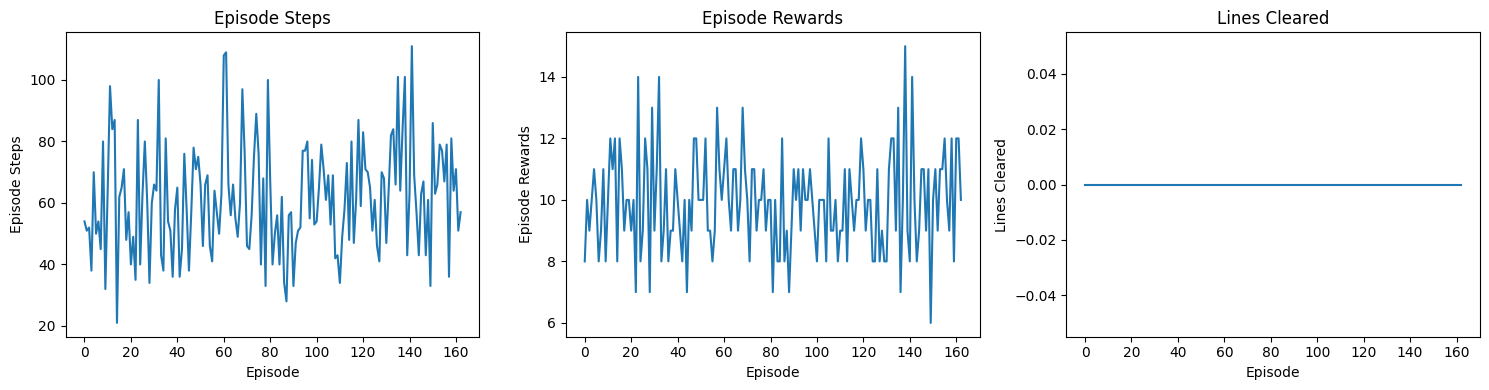

In [12]:
import matplotlib.pyplot as plt

def plot_training_results(metrics: TrainingMetrics, rolling_length: int):
    """Plot episode lengths, rewards, and lines cleared with rolling average."""
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    data = [
        ("Episode Steps", metrics.episode_steps),
        ("Episode Rewards", metrics.episode_rewards),
        ("Lines Cleared", metrics.episode_lines),
    ]
    
    for ax, (title, values) in zip(axes, data):
        ax.set_title(title)
        ax.set_xlabel("Episode")
        ax.set_ylabel(title)
        
        if len(values) >= rolling_length:
            rolling_avg = np.convolve(
                values, 
                np.ones(rolling_length) / rolling_length, 
                mode='valid'
            )
            ax.plot(range(len(rolling_avg)), rolling_avg)
        else:
            ax.plot(values)
    
    plt.tight_layout()
    plt.show()

# Plot results
plot_training_results(metrics, config.plot_rolling_length)